# Amazon Sentiment Analysis
**Objective**: Analyze Amazon reviews and predict their sentiment (positive/negative).


## Import Libraries

In [1]:
# Import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

import re
import emoji
from contractions import contractions_dict

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from tqdm import tqdm

In [2]:
# Download NLTK Datasets
nltk.download('punkt') # Tokenizer
nltk.download('punkt_tab')
nltk.download('stopwords') # Stopwords
nltk.download('wordnet') # WordNet for lemmatization

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tabam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tabam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tabam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tabam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Dataset

In [3]:
# Load the dataset (adjust if needed)
dataset_path = "D:\\Portfolio\\amazon_sentiment_analysis\\data\\raw\\Reviews.csv"

# Load dataset into memory as data frame (avoids tampering the original dataset)
df = pd.read_csv(dataset_path)

In [4]:
# Display first few rows
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Inspect Dataset

In [5]:
# Check the dimension of the dataset
df.shape

(568454, 10)

In [6]:
# Check column names, data types, and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
# Find out which columns null values and how many each have
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
# Find basic statistics of all numerical data
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


## Handling Missing Data

In [9]:
# Add a sentiment column using the score column
df['sentiment'] = df['Score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

In [10]:
# Add a text length to count the number of characters for each review
df['text_length'] = df['Text'].apply(len)

In [11]:
# Drop columns not needed
df.drop(columns = ['ProfileName'],inplace=True)

In [12]:
# Fill missing values in the remaining columns (Summary) with empty string
df['Summary'] = df['Summary'].fillna('')

In [13]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
sentiment                 0
text_length               0
dtype: int64

### Text Preprocessing

We preprocess the review text to prepare it for modeling. The steps include:
1. **Lowercasing**: Normalize the text by converting all characters to lowercase.
2. **Removing Punctuation**: Eliminate symbols like `!` and `.` to focus on the words.
3. **Removing Stopwords**: Remove common words like "the" and "is" that don’t contribute to sentiment.
4. **Tokenization**: Split text into individual words.
5. **Lemmatization**: Reduce words to their base form (e.g., "running" → "run").


In [14]:
def combine_negations(tokens):
    """
    Combines 'not' with the following word to preserve sentiment.
    Example: ['not', 'happy'] → ['not_happy']
    """
    
    result = []
    i = 0
    while i < len(tokens):
        if tokens[i] == 'not' and i+1 < len(tokens):
            result.append(f"not_{tokens[i+1]}")
        else:
            result.append(tokens[i])
            i += 1

    return result

In [15]:
# Define proprocessing function
def preprocess_text(text):
    """
    Comprehensive preprocessing of the input text:
    1. Expand contracations
    2. Translate emojis/emoticons into words
    3. Handle repeated punctuation (!, ?)
    4. Convert to lowercase
    5. Remove punctuation (except !, ?)
    6. Tokenize
    7. Remove stopwords
    8. Handle negations
    9. Lemmatize tokens
    10. Remove extra whitespaces

    Args:
    - text (str): The raw input data

    Returns:
    - str: The cleaned and preprocessed text
    """

    # 1. Expand contractions
    for contraction, expanded in contractions_dict.items():
        text = text.replace(contraction, expanded)

    # 2. Replace emojis and emoticons
    text = emoji.demojize(text)
    text = re.sub(r'(\w+):',r'\1',text)

    # 3. Handle repeated punctuation
    text = re.sub(r'!+',' <emphasis> ', text)
    text = re.sub(r'\?+',' <doubt> ', text)

    # 4. Convert to lowercase
    text = text.lower()

    # 5. Remove punctuation
    text = text.translate(str.maketrans('','', string.punctuation.replace('!','').replace('?','')))

    # 6. Tokenize
    tokens = word_tokenize(text)

    # 7. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 8. Handle negations
    tokens = combine_negations(tokens)

    # 9. lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 10. Remove whitespaces
    text = ' '.join(tokens)


    return text

In [16]:
# Apply counting for ! and ? features:
df['exclamation_count'] = df['Text'].apply(lambda x: x.count('!'))
df['question_count'] = df['Text'].apply(lambda x: x.count('?'))

In [17]:
tqdm.pandas()

In [18]:
# Run all preprocessing steps iwth progress bar
df['cleaned_text'] = df['Text'].progress_apply(preprocess_text)

100%|██████████████████████████████████████████████████████| 568454/568454 [12:39<00:00, 748.47it/s]


## Feature Engineering

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

In [22]:
# Fit the vectorizer on the cleaned text and transform it
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])


## Model Training

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
# Define feature and targets
X = tfidf_matrix # features
y = df['sentiment'] # target

In [25]:
# # Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model on the training data
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [27]:
# Predict sentiments on the test set
y_pred = logreg.predict(X_test)


In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8645187393901013


In [29]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.67      0.70     16407
     neutral       0.52      0.18      0.26      8528
    positive       0.90      0.97      0.93     88756

    accuracy                           0.86    113691
   macro avg       0.72      0.60      0.63    113691
weighted avg       0.84      0.86      0.85    113691



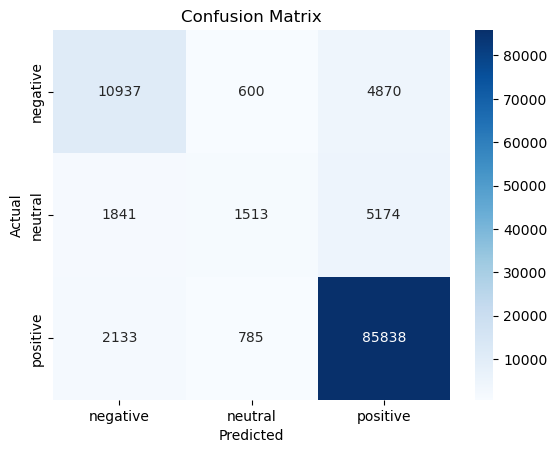

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Training Data Resampled
Due to the class imbalance of positive sentiment being the majority, the dataset needs to be further normalized for a better sentiment analysis

In [33]:
from imblearn.over_sampling import SMOTE

In [34]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(pd.Series(y_train_resampled).value_counts())


sentiment
positive    355021
negative    355021
neutral     355021
Name: count, dtype: int64


In [35]:
# Initialize the Resampled Logistic Regression model
logreg_resample = LogisticRegression(max_iter=1000)

# Train the model on the training data
logreg_resample.fit(X_train_resampled, y_train_resampled)


LogisticRegression(max_iter=1000)

In [37]:
# Predict sentiments on the test set
y_pred_resample = logreg_resample.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_resample))

Accuracy: 0.783993455946381


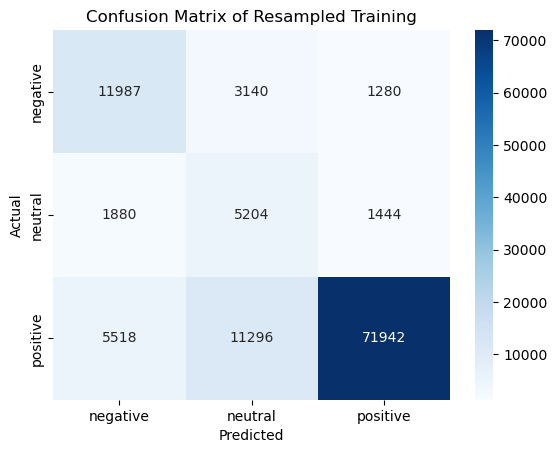

In [38]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_resample)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Resampled Training')
plt.show()


## Balanced Class Weights


In [39]:
# Initialize Logistic Regression with balanced class weights
logreg_balance = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
logreg_balance.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [41]:
# Predict sentiments on the test set
y_pred_balance = logreg_balance.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_balance))

Accuracy: 0.7774933811823276


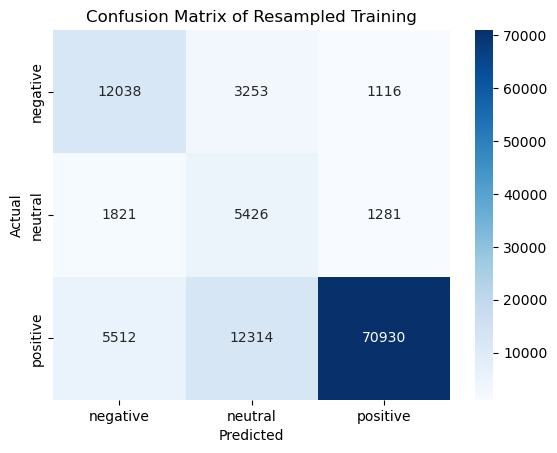

In [42]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_balance)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Resampled Training')
plt.show()


## Different Algorithms

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize the Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200)

# Train the model
rf.fit(X_train, y_train)

In [ ]:
# Predict and evaluate
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))